In [191]:
import numpy as np
import pandas as pd
import os
import json
import sys
import matplotlib.pyplot as plt
import snowflake.snowpark.types as T

from dotenv import load_dotenv
from snowflake.snowpark import Session

# from statsmodels.tsa.statespace.sarimax import SARIMAX
# import pmdarima as pm

In [192]:
load_dotenv()

# Connect to Snowflake
USER = os.getenv("SNOWFLAKE_USER")
PASSWORD = os.getenv("SNOWFLAKE_PASSWORD")
ACCOUNT = os.getenv("SNOWFLAKE_ACCOUNT")
WAREHOUSE = os.getenv("SNOWFLAKE_WAREHOUSE")
DATABASE = os.getenv("SNOWFLAKE_DATABASE")
SCHEMA = os.getenv("SNOWFLAKE_SCHEMA")
ROLE = os.getenv("SNOWFLAKE_ROLE")

In [193]:
connection_parameters = {
    "account": ACCOUNT,
    "user": USER,
    "password": PASSWORD,
    "role": ROLE,
    "warehouse": WAREHOUSE,
    "database": DATABASE,
    "schema": SCHEMA,
}

# create Snowpark session
session = Session.builder.configs(connection_parameters).create()

c:\Users\panha.vuthy\AppData\Local\Programs\Python\Python311\Lib\site-packages\snowflake\connector\config_manager.py:351: UserWarning: Bad owner or permissions on C:\Users\panha.vuthy\AppData\Local\snowflake\config.toml
  warn(f"Bad owner or permissions on {str(filep)}{chmod_message}")


## Data Collection

In [194]:
# query and filling data with 0 is done in Snowflake
def get_data(product_sku, customer_segment):
    data = session.sql(f"""
    WITH sales_data AS (
    SELECT 
        FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE AS "DATE",
        LU_CUS_RFM_SEGMENT.RFM_SEGMENT_CODE AS "CUSTOMER_SEGMENT",
        SUM(FACT_ORDER_LINE_ITEM_BASE.ORDERED_QUANTITY) AS "UNITS_SOLD"
    FROM 
        FACT_ORDER_LINE_ITEM_BASE
    LEFT JOIN 
        LU_PRD_PRODUCT
    ON 
        FACT_ORDER_LINE_ITEM_BASE.PRODUCT_CODE = LU_PRD_PRODUCT.PRODUCT_CODE
    LEFT JOIN 
        LU_PRD_PRODUCT_SKU
    ON 
        LU_PRD_PRODUCT_SKU.PRODUCT_SKU = LU_PRD_PRODUCT.PRODUCT_SKU
    LEFT JOIN 
        LU_CUS_CUSTOMER 
    ON 
        FACT_ORDER_LINE_ITEM_BASE.CUSTOMER_CODE = LU_CUS_CUSTOMER.CUSTOMER_CODE
    LEFT JOIN 
        LU_CUS_RFM_SEGMENT
    ON 
        LU_CUS_RFM_SEGMENT.RFM_SEGMENT_CODE = LU_CUS_CUSTOMER.RFM_SEGMENT_CODE
    WHERE 
        LU_PRD_PRODUCT_SKU.PRODUCT_SKU IN ('{product_sku}')
        AND LU_CUS_RFM_SEGMENT.RFM_SEGMENT_CODE = {customer_segment}
    GROUP BY 
        FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE, LU_CUS_RFM_SEGMENT.RFM_SEGMENT_CODE
),

date_range AS (
    SELECT 
        MIN(FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE) AS MIN_DATE,
        MAX(FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE) AS MAX_DATE
    FROM 
        FACT_ORDER_LINE_ITEM_BASE
    LEFT JOIN 
        LU_PRD_PRODUCT
    ON 
        FACT_ORDER_LINE_ITEM_BASE.PRODUCT_CODE = LU_PRD_PRODUCT.PRODUCT_CODE
    LEFT JOIN
        LU_PRD_PRODUCT_SKU
    ON 
        LU_PRD_PRODUCT.PRODUCT_SKU = LU_PRD_PRODUCT_SKU.PRODUCT_SKU
    WHERE 
        LU_PRD_PRODUCT_SKU.PRODUCT_SKU IN ('{product_sku}')
)

SELECT 
    LU_CAL_DATE.DATE AS "DATE",
    COALESCE(sales_data.CUSTOMER_SEGMENT, {customer_segment}) AS "CUSTOMER_SEGMENT",
    COALESCE(sales_data.UNITS_SOLD, 0) AS "UNITS_SOLD"
FROM 
    LU_CAL_DATE
LEFT JOIN 
    sales_data
ON 
    LU_CAL_DATE.DATE = sales_data.DATE
JOIN 
    date_range
ON 
    LU_CAL_DATE.DATE BETWEEN date_range.MIN_DATE AND date_range.MAX_DATE
WHERE 
    YEAR(LU_CAL_DATE.DATE) BETWEEN 2021 AND 2023
ORDER BY 
    LU_CAL_DATE.DATE ASC;
    """).collect()
    return data

In [195]:

# data_collection = get_data("B33_S3", 0)
# data_frame = pd.DataFrame(data_collection)

In [196]:
customer_segement = [1, 2, 3, 4, 5, 6, 7, 8, 9]
product_sku = "B12_S10"

In [197]:
data_collection = {}
for segment in customer_segement:
    data = pd.DataFrame(get_data(product_sku, segment))
    data_collection[segment] = data
# data_frame = pd.DataFrame(data_collection)

## Data Exploratory

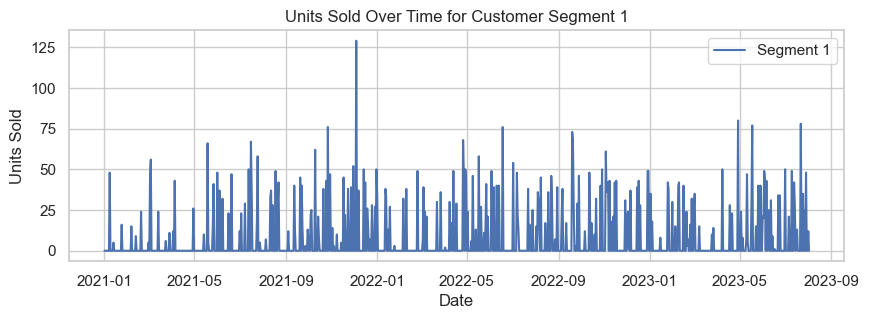

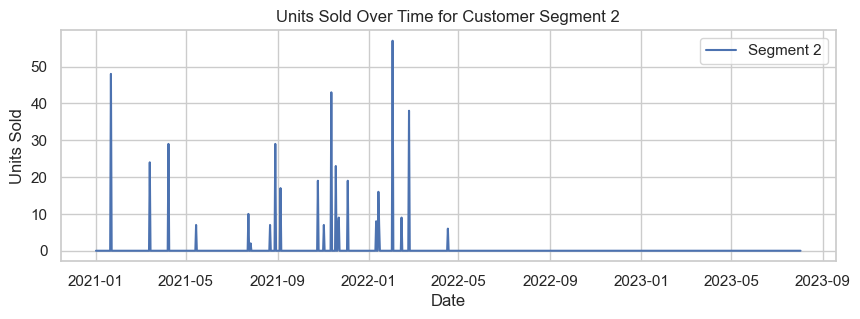

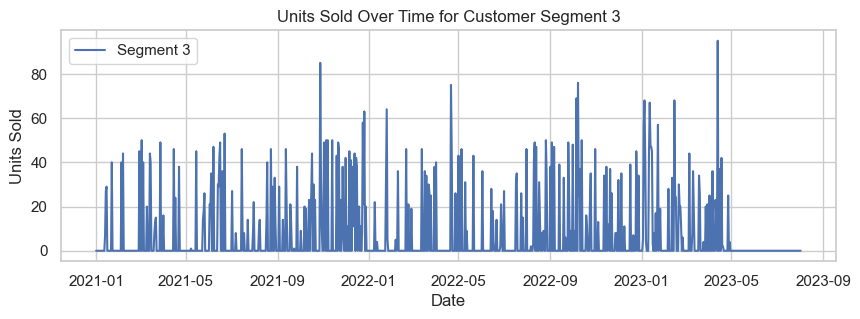

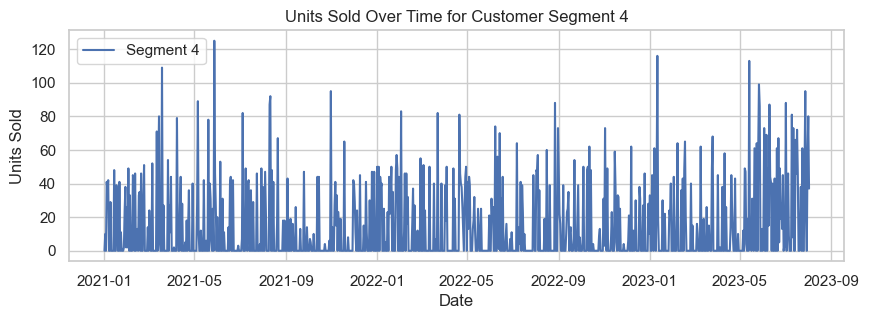

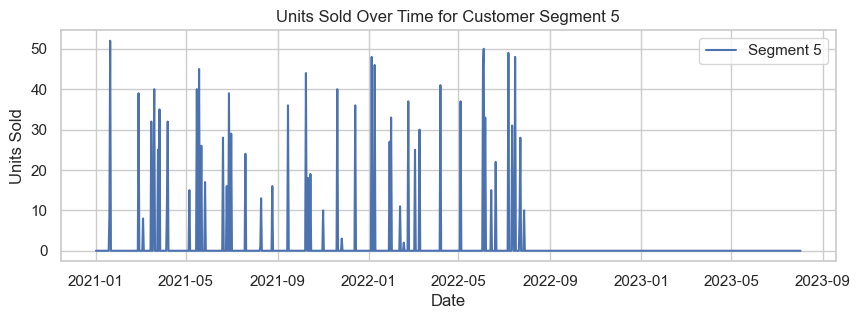

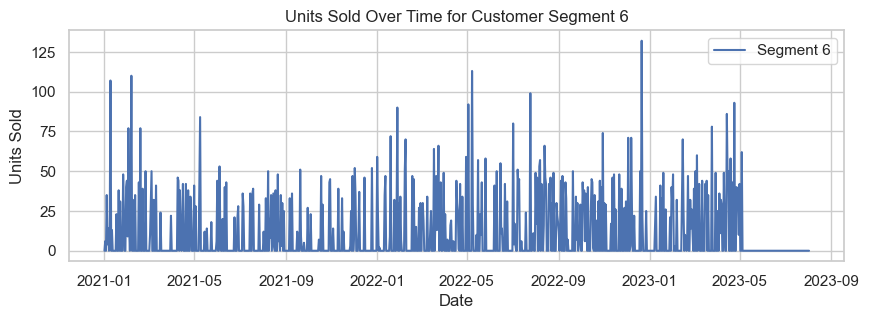

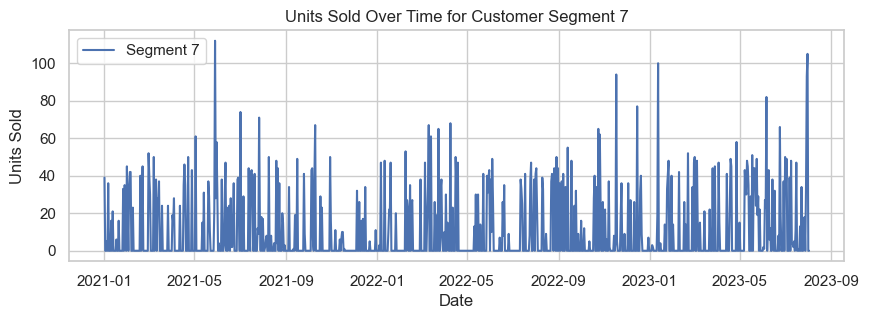

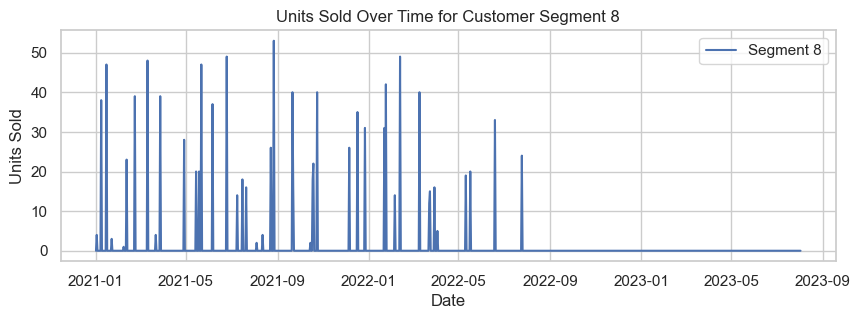

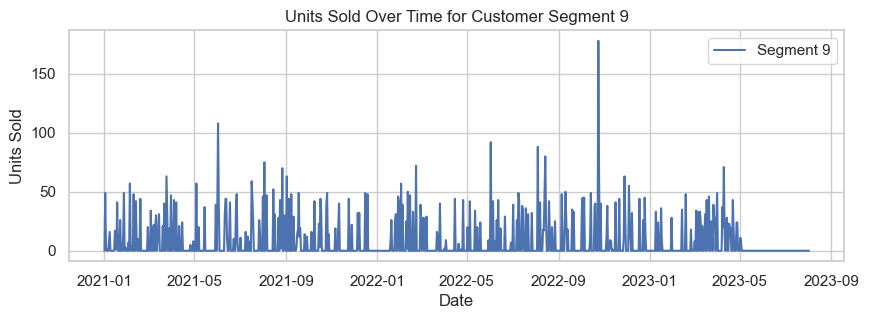

In [198]:
# Plot the time series data for each customer segment
for segment, data in data_collection.items():
    plt.figure(figsize=(10, 3))
    plt.plot(data['DATE'], data['UNITS_SOLD'], label=f'Segment {segment}')
    
    # Add title and labels
    plt.title(f'Units Sold Over Time for Customer Segment {segment}')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    
    # Show the plot
    plt.show()

Statistical Testing

In [199]:
from statsmodels.tsa.stattools import adfuller

stationarity_results = {}

for segment, data in data_collection.items():
    if data['UNITS_SOLD'].nunique() == 1:
        # Skip this segment as UNIT_SOLD is constant
        continue
    result = adfuller(data['UNITS_SOLD'])
    stationarity_results[segment] = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Stationary': result[1] <= 0.05
    }
    # Unit Solds is all Zero, continue to next segment
    if result[1] > 0.05:
        continue

stationarity_results

{1: {'ADF Statistic': -30.4588280271941, 'p-value': 0.0, 'Stationary': True},
 2: {'ADF Statistic': -4.550556936125083,
  'p-value': 0.00015916690208948867,
  'Stationary': True},
 3: {'ADF Statistic': -6.5593824123389295,
  'p-value': 8.456255761511713e-09,
  'Stationary': True},
 4: {'ADF Statistic': -8.685463911049654,
  'p-value': 4.175076875270729e-14,
  'Stationary': True},
 5: {'ADF Statistic': -13.079437311092214,
  'p-value': 1.884172753891158e-24,
  'Stationary': True},
 6: {'ADF Statistic': -5.667720966963999,
  'p-value': 9.070491023997452e-07,
  'Stationary': True},
 7: {'ADF Statistic': -27.64742658871455, 'p-value': 0.0, 'Stationary': True},
 8: {'ADF Statistic': -30.789837795236895, 'p-value': 0.0, 'Stationary': True},
 9: {'ADF Statistic': -15.825778159632398,
  'p-value': 1.0077553803430528e-28,
  'Stationary': True}}

## Data Preprocessing
Outlier Treatment

In [200]:
# from scipy import stats

# # Function to detect and treat outliers
# def treat_outliers(data):
#     z_scores = np.abs(stats.zscore(data['UNITS_SOLD']))
#     outliers = np.where(z_scores > 3)[0]
#     mean_value = data['UNITS_SOLD'].mean()
#     data.loc[outliers, 'UNITS_SOLD'] = mean_value
#     return data

# # Apply the function to each segment's data
# for segment in data_collection:
#     data_collection[segment] = treat_outliers(data_collection[segment])

# data_collection

## Model Training

In [201]:
import pmdarima as pm
from matplotlib import pyplot as plt

In [202]:
# forecast_df['UNITS_SOLD'] = forecast.values

In [203]:
# Dictionary to store forecast results for each segment
import joblib

forecast_results = {}

for segment, result in stationarity_results.items():
    if result['Stationary']:
        # Get the data for the segment
        segment_data = data_collection[segment]
        
        # Ensure UNITS_SOLD is numeric
        segment_data['UNITS_SOLD'] = pd.to_numeric(segment_data['UNITS_SOLD'])
        
        # Fit the auto_arima model
        model = pm.auto_arima(segment_data['UNITS_SOLD'],
                              max_p=3, max_d=3, max_q=3,
                              seasonal=True,
                              m=7,
                              max_P=3, max_D=2, max_Q=3,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)
        
        # save model
        # Create the directory for saving models if it doesn't exist
        model_dir = f'./models/{product_sku}/'
        os.makedirs(model_dir, exist_ok=True)
        
        # Save the model
        model_path = f'{model_dir}{product_sku}_c{segment}.pkl'
        joblib.dump(model, model_path)

        # Predict future sales
        n_periods = 7
        forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
        
        # Create a DataFrame for the forecast
        forecast_index = pd.date_range(start=segment_data['DATE'].iloc[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D')
        forecast_df = pd.DataFrame(forecast, columns=['UNITS_SOLD'], index=forecast_index)
        forecast_df['UNITS_SOLD'] = forecast.values
        
        # Store the forecast results
        forecast_results[segment] = {
            'forecast': forecast_df,
            'conf_int': conf_int,
            'best_order': model.order,
            'best_params': model.get_params()
        }

forecast_results

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=14.48 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=8568.171, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=8295.531, Time=1.83 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=6.88 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=8566.171, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=8295.718, Time=0.23 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=8297.530, Time=2.47 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=8297.529, Time=1.93 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=8295.529, Time=1.69 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=8297.527, Time=2.24 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=9.24 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=8568.001, Time=0.98 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=8174.412, Time=1.58 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=8174.239, Time=1.05 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=8174.

{1: {'forecast':             UNITS_SOLD
  2023-08-03     9.52471
  2023-08-04     9.52471
  2023-08-05     9.52471
  2023-08-06     9.52471
  2023-08-07     9.52471
  2023-08-08     9.52471
  2023-08-09     9.52471,
  'conf_int': array([[-21.99042936,  41.03984905],
         [-21.99236827,  41.04178796],
         [-21.99430706,  41.04372676],
         [-21.99624574,  41.04566543],
         [-21.9981843 ,  41.04760399],
         [-22.00012273,  41.04954243],
         [-22.00206105,  41.05148074]]),
  'best_order': (0, 1, 1),
  'best_params': {'maxiter': 50,
   'method': 'lbfgs',
   'order': (0, 1, 1),
   'out_of_sample_size': 0,
   'scoring': 'mse',
   'scoring_args': {},
   'seasonal_order': (0, 0, 0, 7),
   'start_params': None,
   'suppress_warnings': True,
   'trend': None,
   'with_intercept': False}},
 2: {'forecast':             UNITS_SOLD
  2023-08-03    0.009246
  2023-08-04    0.009637
  2023-08-05    0.004575
  2023-08-06    0.009046
  2023-08-07    0.005250
  2023-08-08    0

In [204]:
data_collection

{1:            DATE  CUSTOMER_SEGMENT  UNITS_SOLD
 0    2021-01-01                 1         0.0
 1    2021-01-02                 1         0.0
 2    2021-01-03                 1         0.0
 3    2021-01-04                 1         0.0
 4    2021-01-05                 1         0.0
 ..          ...               ...         ...
 939  2023-07-29                 1        48.0
 940  2023-07-30                 1         0.0
 941  2023-07-31                 1         0.0
 942  2023-08-01                 1        12.0
 943  2023-08-02                 1         0.0
 
 [944 rows x 3 columns],
 2:            DATE  CUSTOMER_SEGMENT  UNITS_SOLD
 0    2021-01-01                 2         0.0
 1    2021-01-02                 2         0.0
 2    2021-01-03                 2         0.0
 3    2021-01-04                 2         0.0
 4    2021-01-05                 2         0.0
 ..          ...               ...         ...
 939  2023-07-29                 2         0.0
 940  2023-07-30           

Forecast for Customer Segment 1:
            UNITS_SOLD
2023-08-03     9.52471
2023-08-04     9.52471
2023-08-05     9.52471
2023-08-06     9.52471
2023-08-07     9.52471
2023-08-08     9.52471
2023-08-09     9.52471



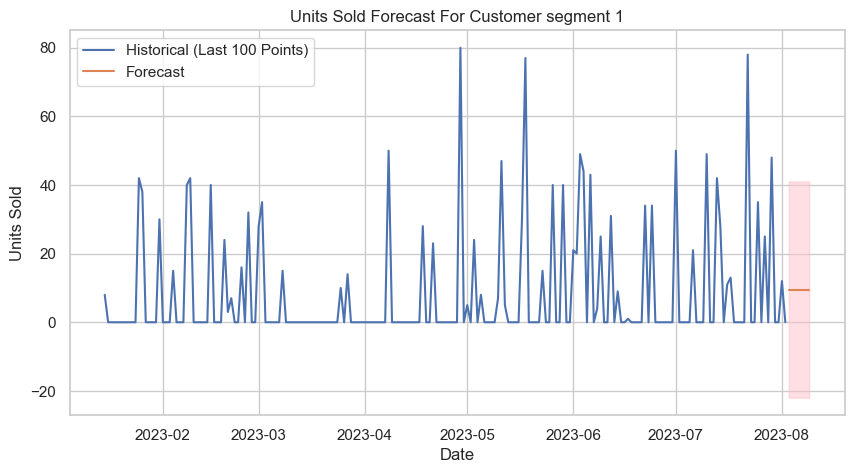

Forecast for Customer Segment 2:
            UNITS_SOLD
2023-08-03    0.009246
2023-08-04    0.009637
2023-08-05    0.004575
2023-08-06    0.009046
2023-08-07    0.005250
2023-08-08    0.009095
2023-08-09    0.008810



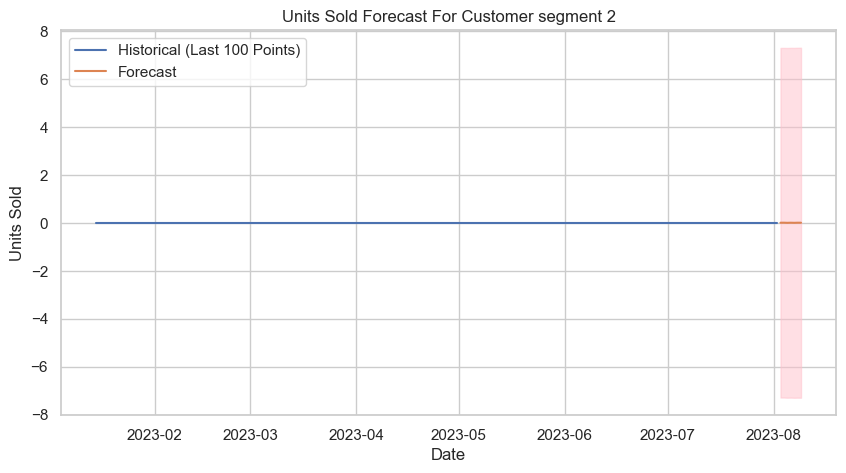

Forecast for Customer Segment 3:
            UNITS_SOLD
2023-08-03    3.096602
2023-08-04    3.247777
2023-08-05    3.393299
2023-08-06    3.533379
2023-08-07    3.668222
2023-08-08    3.798022
2023-08-09    3.922968



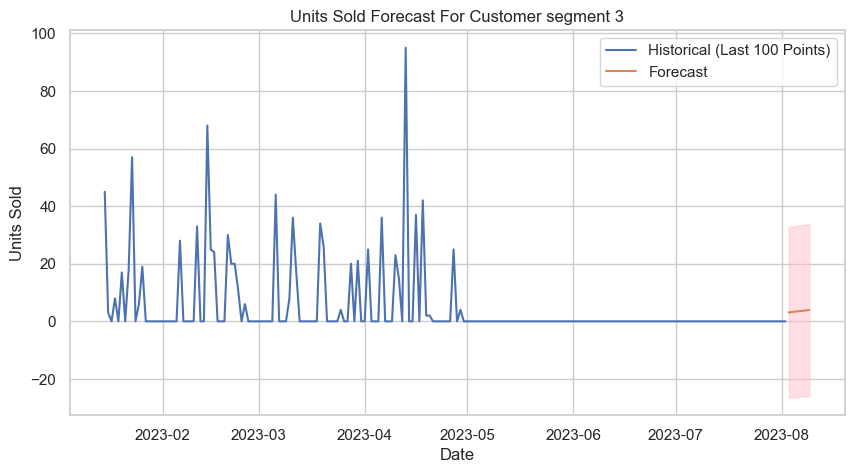

Forecast for Customer Segment 4:
            UNITS_SOLD
2023-08-03   27.702524
2023-08-04   27.702524
2023-08-05   27.702524
2023-08-06   27.702524
2023-08-07   27.702524
2023-08-08   27.702524
2023-08-09   27.702524



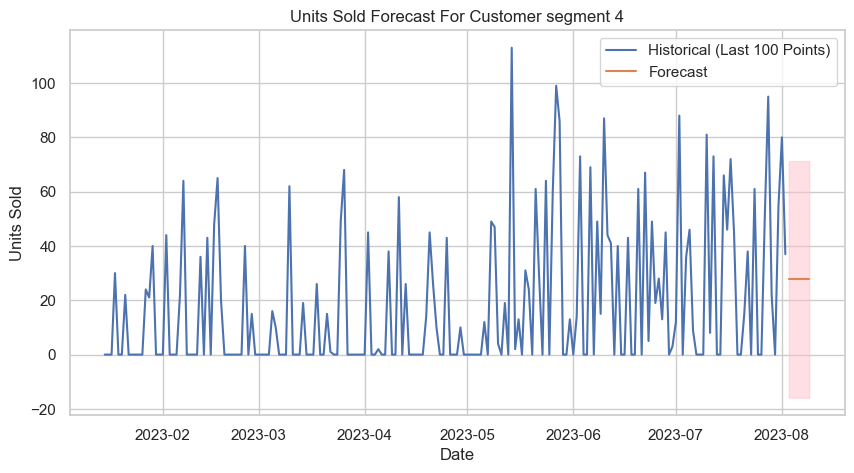

Forecast for Customer Segment 5:
            UNITS_SOLD
2023-08-03    0.034118
2023-08-04    0.034118
2023-08-05    0.034118
2023-08-06    0.034118
2023-08-07    0.034118
2023-08-08    0.034118
2023-08-09    0.034118



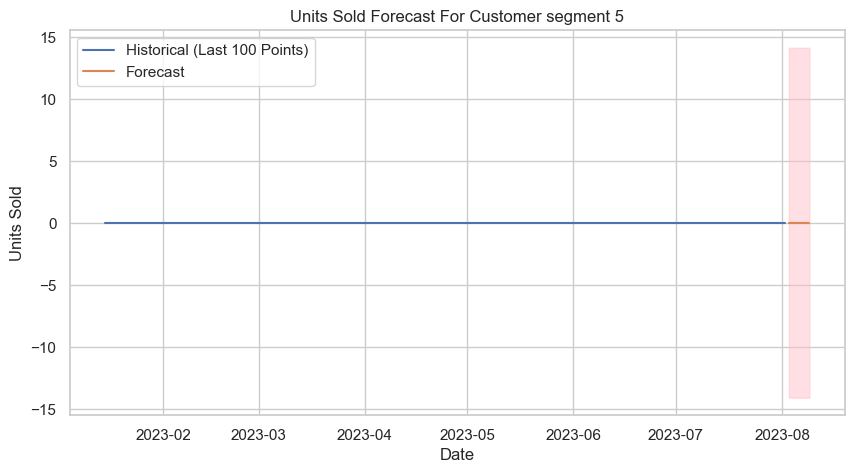

Forecast for Customer Segment 6:
            UNITS_SOLD
2023-08-03   10.325005
2023-08-04   10.325005
2023-08-05   10.325005
2023-08-06   10.325005
2023-08-07   10.325005
2023-08-08   10.325005
2023-08-09   10.325005



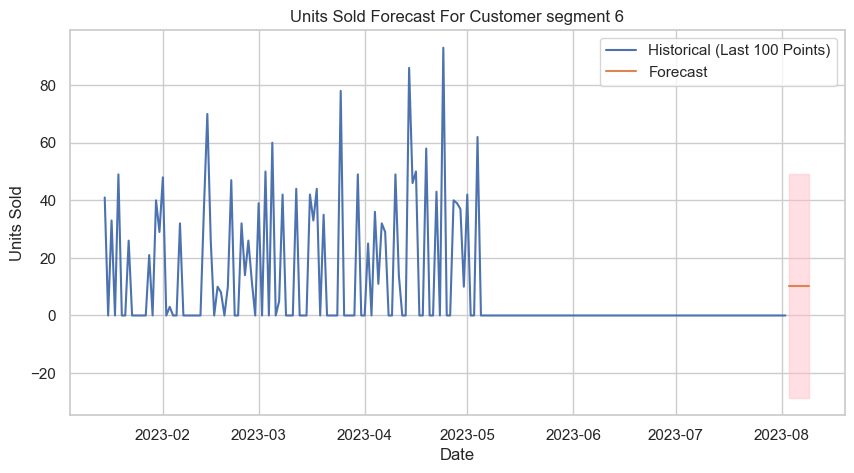

Forecast for Customer Segment 7:
            UNITS_SOLD
2023-08-03   11.182899
2023-08-04   10.736571
2023-08-05   10.503110
2023-08-06   10.380993
2023-08-07   10.317118
2023-08-08   10.283706
2023-08-09   10.266230



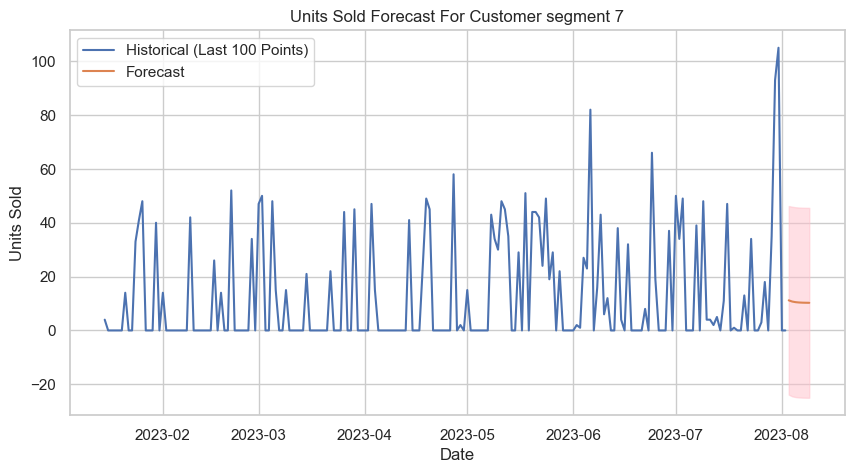

Forecast for Customer Segment 8:
               UNITS_SOLD
2023-08-03 -6.916919e-323
2023-08-04 -6.916919e-323
2023-08-05 -6.916919e-323
2023-08-06 -6.916919e-323
2023-08-07 -6.916919e-323
2023-08-08 -6.916919e-323
2023-08-09 -6.916919e-323



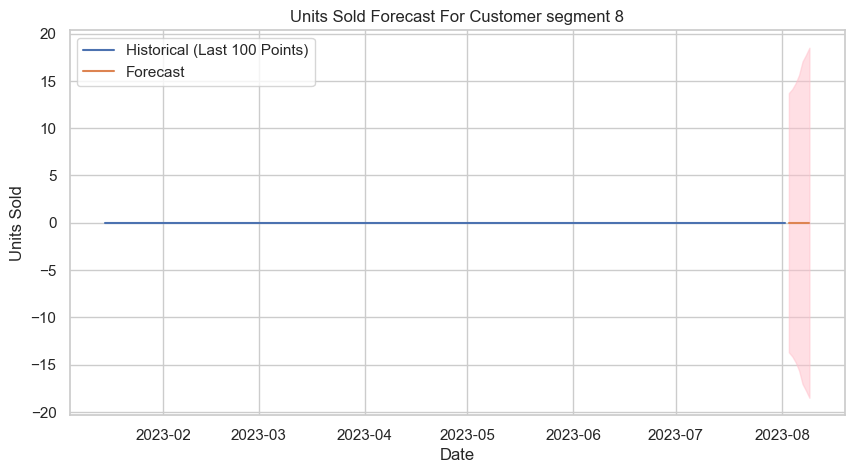

Forecast for Customer Segment 9:
            UNITS_SOLD
2023-08-03    4.202677
2023-08-04    4.611950
2023-08-05    4.551907
2023-08-06    4.801812
2023-08-07    4.834361
2023-08-08    5.006824
2023-08-09    5.077578



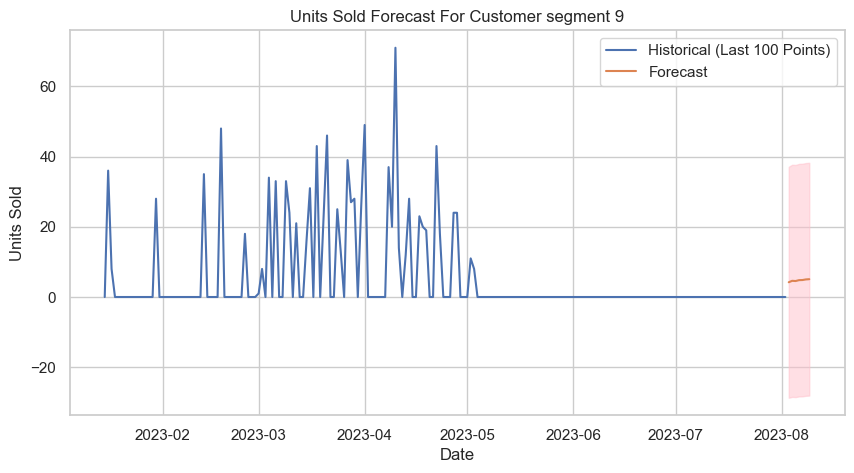

In [205]:
for segment, result in forecast_results.items():
    print(f"Forecast for Customer Segment {segment}:\n{result['forecast']}\n")
    # print(f"{data_collection[segment]['UNITS_SOLD'].iloc[-100:]}")
    # Get the forecast and confidence interval
    forecast_df = result['forecast']
    conf_int = result['conf_int']

    df_plot = data_collection[segment].copy()
    df_plot['DATE'] = pd.to_datetime(df_plot['DATE'])
    df_plot.set_index('DATE', inplace=True)
    # Plot the results
    plt.figure(figsize=(10, 5))
    
    # Plot the last 100 historical points
    plt.plot(df_plot['UNITS_SOLD'][-200:], label='Historical (Last 100 Points)')
    
    # Plot the forecast points
    plt.plot(forecast_df['UNITS_SOLD'], label='Forecast')
    plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.5)
    
    # Add title and labels
    plt.title(f"Units Sold Forecast For Customer segment {segment}")
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    
    # Show the plot
    plt.show()

In [206]:
# Treat outliers in the 'NUM_ORDERS' column
def treat_outliers(df, column, outlier_percentages):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # if any of the numerical columns have outliers that under 5%, we can keep them, otherwise we treat theme with mean imputation
    if outlier_percentages[column] < 5:
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    else:
        df[column] = np.where(df[column] < lower_bound, df[column].mean(), df[column])
        df[column] = np.where(df[column] > upper_bound, df[column].mean(), df[column])
    return df

In [207]:
raw_data = session.sql(f"""
SELECT 
    FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE AS "DATE",
    LU_PRD_PRODUCT_SKU.PRODUCT_SKU_RETAIL_PRICE AS "RETAIL_RPICE",
    LU_CUS_RFM_SEGMENT.RFM_SEGMENT_CODE AS "CUSTOMER_SEGMENT",
    COUNT(DISTINCT(FACT_ORDER_LINE_ITEM_BASE.ORDER_CODE)) AS "NUM_ORDERS",
    SUM(FACT_ORDER_LINE_ITEM_BASE.ORDERED_QUANTITY) AS "UNITS_SOLD",
    AVG(FACT_ORDER_LINE_ITEM_BASE.DISCOUNT_RATE) AS "AVG_DISCOUNT_RATE",
    SUM(FACT_ORDER_LINE_ITEM_BASE.SUPPLY_UNIT_COST) AS "COGS",
FROM 
    LU_PRD_PRODUCT_SKU
JOIN 
    LU_PRD_PRODUCT
ON 
    LU_PRD_PRODUCT_SKU.PRODUCT_SKU = LU_PRD_PRODUCT.PRODUCT_SKU
JOIN 
    FACT_ORDER_LINE_ITEM_BASE 
ON 
    FACT_ORDER_LINE_ITEM_BASE.PRODUCT_CODE = LU_PRD_PRODUCT.PRODUCT_CODE
JOIN 
    LU_CUS_CUSTOMER 
ON
    LU_CUS_CUSTOMER.CUSTOMER_CODE = FACT_ORDER_LINE_ITEM_BASE.CUSTOMER_CODE
JOIN 
    LU_CUS_RFM_SEGMENT
ON
    LU_CUS_RFM_SEGMENT.RFM_SEGMENT_CODE = LU_CUS_CUSTOMER.RFM_SEGMENT_CODE
WHERE
    LU_PRD_PRODUCT_SKU.PRODUCT_SKU IN  ('{product_sku}')
    AND (YEAR(FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE) BETWEEN 2021 AND 2023)
GROUP BY
    DATE, RETAIL_RPICE, CUSTOMER_SEGMENT
ORDER BY
    DATE ASC
""").collect()

In [208]:
df_raw_data = pd.DataFrame(raw_data)

In [209]:
df_raw_data

,DATE,RETAIL_RPICE,CUSTOMER_SEGMENT,NUM_ORDERS,UNITS_SOLD,AVG_DISCOUNT_RATE,COGS
0,2021-01-01,1493.11465,7,1,39.00,0.09000000,843.43
1,2021-01-02,1493.11465,9,1,49.00,0.08000000,851.13
2,2021-01-02,1493.11465,8,1,4.00,0.05000000,318.59
3,2021-01-02,1493.11465,6,1,6.00,0.10000000,963.42
4,2021-01-02,1493.11465,4,1,10.00,0.10000000,450.51
...,...,...,...,...,...,...,...
1865,2023-07-31,1493.11465,4,2,55.00,0.03000000,1586.30
1866,2023-07-31,1493.11465,7,4,105.00,0.03750000,2165.67
1867,2023-08-01,1493.11465,1,1,12.00,0.01000000,781.34
1868,2023-08-01,1493.11465,4,3,80.00,0.05333333,1399.48


In [210]:
print(f"Number of rows: {df_raw_data.shape[0]}")
print(f"Number of columns: {df_raw_data.shape[1]}")

Number of rows: 1870
Number of columns: 7


In [211]:
print("Checking Column Data Types")
df_raw_data.info()

Checking Column Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1870 entries, 0 to 1869
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DATE               1870 non-null   object 
 1   RETAIL_RPICE       1870 non-null   float64
 2   CUSTOMER_SEGMENT   1870 non-null   int64  
 3   NUM_ORDERS         1870 non-null   int64  
 4   UNITS_SOLD         1870 non-null   object 
 5   AVG_DISCOUNT_RATE  1870 non-null   object 
 6   COGS               1870 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 102.4+ KB


In [212]:
# Convert UUNIT_SOLD to int, AVG_DISCOUNT_RATE to float, and COGS to float
df_raw_data['UNITS_SOLD'] = df_raw_data['UNITS_SOLD'].astype(int)
df_raw_data['AVG_DISCOUNT_RATE'] = df_raw_data['AVG_DISCOUNT_RATE'].astype(float)
df_raw_data['COGS'] = df_raw_data['COGS'].astype(float)

#Convert Customer Segment to Category
df_raw_data['CUSTOMER_SEGMENT'] = df_raw_data['CUSTOMER_SEGMENT'].astype('category')

In [213]:
print("Descriptive Statistics on numerical columns")
df_raw_data.describe(include=[np.number])

Descriptive Statistics on numerical columns


,RETAIL_RPICE,NUM_ORDERS,UNITS_SOLD,AVG_DISCOUNT_RATE,COGS
count,1.870000e+03,1870.000000,1870.000000,1870.000000,1870.000000
mean,1.493115e+03,1.209091,31.102139,0.049704,609.721139
std,4.548690e-13,0.501067,20.066762,0.030045,414.475853
min,1.493115e+03,1.000000,1.000000,0.000000,4.240000
25%,1.493115e+03,1.000000,15.000000,0.025000,309.190000
50%,1.493115e+03,1.000000,30.000000,0.050000,579.550000
75%,1.493115e+03,1.000000,43.000000,0.070000,843.430000
max,1.493115e+03,5.000000,178.000000,0.100000,2989.780000


In [214]:
print("Descriptive Statistics on categorical columns")
df_raw_data.describe(include=[pd.Categorical, 'category'])

Descriptive Statistics on categorical columns


,DATE,CUSTOMER_SEGMENT
count,1870,1870
unique,869,9
top,2021-10-15,4
freq,7,381


In [215]:
df_raw_data.isnull().sum()

DATE                 0
RETAIL_RPICE         0
CUSTOMER_SEGMENT     0
NUM_ORDERS           0
UNITS_SOLD           0
AVG_DISCOUNT_RATE    0
COGS                 0
dtype: int64

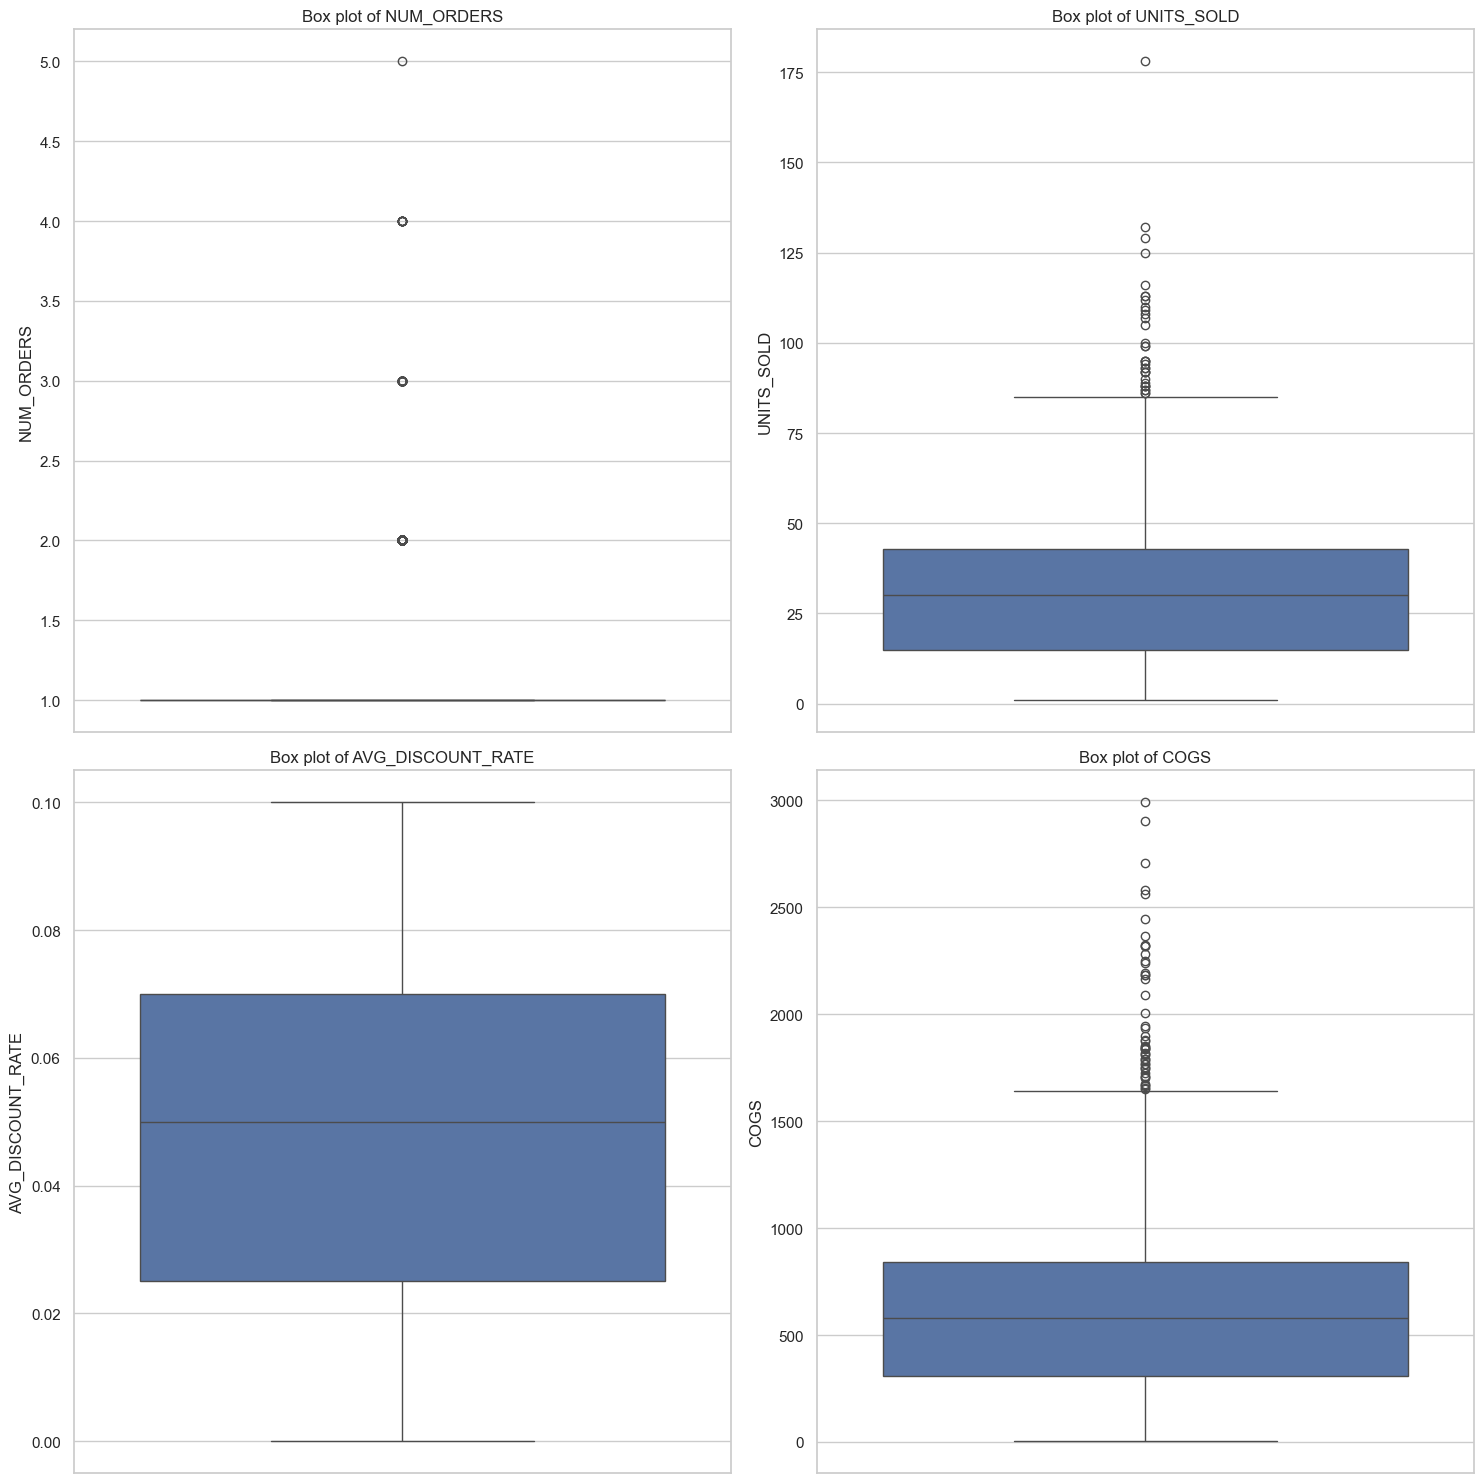

In [216]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the style of the visualization
sns.set_theme(style="whitegrid")

# Create a figure and axis
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# List of numerical columns to plot
numerical_columns = ['NUM_ORDERS', 'UNITS_SOLD', 'AVG_DISCOUNT_RATE', 'COGS']

# Plot each numerical column
for ax, column in zip(axes.flatten(), numerical_columns):
    sns.boxplot(y=df_raw_data[column], ax=ax)
    ax.set_title(f'Box plot of {column}')

# Adjust layout
plt.tight_layout()
plt.show()

In [217]:
# Calculate the percentage of outliers for each numerical column
outlier_percentages = {}

for column in numerical_columns:
    Q1 = df_raw_data[column].quantile(0.25)
    Q3 = df_raw_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_raw_data[(df_raw_data[column] < lower_bound) | (df_raw_data[column] > upper_bound)]
    outlier_percentage = (len(outliers) / len(df_raw_data)) * 100
    outlier_percentages[column] = outlier_percentage


print("Percentage of outliers in each numerical column")
for column, percentage in outlier_percentages.items():
    print(f"{column}: {percentage:.2f}%")

Percentage of outliers in each numerical column
NUM_ORDERS: 17.33%
UNITS_SOLD: 1.82%
AVG_DISCOUNT_RATE: 0.00%
COGS: 2.62%


In [218]:
# Treat outliers in the 'NUM_ORDERS' column
def treat_outliers(df, column, outlier_percentages):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # if any of the numerical columns have outliers that under 5%, we can keep them, otherwise we treat theme with mean imputation
    if outlier_percentages[column] > 5:
        df[column] = np.where(df[column] < lower_bound, df[column].mean(), df[column])
        df[column] = np.where(df[column] > upper_bound, df[column].mean(), df[column])
    return df

In [219]:
df_raw_data = treat_outliers(df_raw_data, 'NUM_ORDERS', outlier_percentages)
df_raw_data = treat_outliers(df_raw_data, 'UNITS_SOLD', outlier_percentages)
df_raw_data = treat_outliers(df_raw_data, 'AVG_DISCOUNT_RATE', outlier_percentages)
df_raw_data = treat_outliers(df_raw_data, 'COGS', outlier_percentages)

In [220]:
print(f'% of outliers in each numerical column')
for column, percentage in outlier_percentages.items():
    print(f"{column}: {percentage:.2f}%")

% of outliers in each numerical column
NUM_ORDERS: 17.33%
UNITS_SOLD: 1.82%
AVG_DISCOUNT_RATE: 0.00%
COGS: 2.62%


In [221]:
# check duplicate rows
duplicate_rows = df_raw_data[df_raw_data.duplicated()]
duplicate_rows.count()

DATE                 0
RETAIL_RPICE         0
CUSTOMER_SEGMENT     0
NUM_ORDERS           0
UNITS_SOLD           0
AVG_DISCOUNT_RATE    0
COGS                 0
dtype: int64

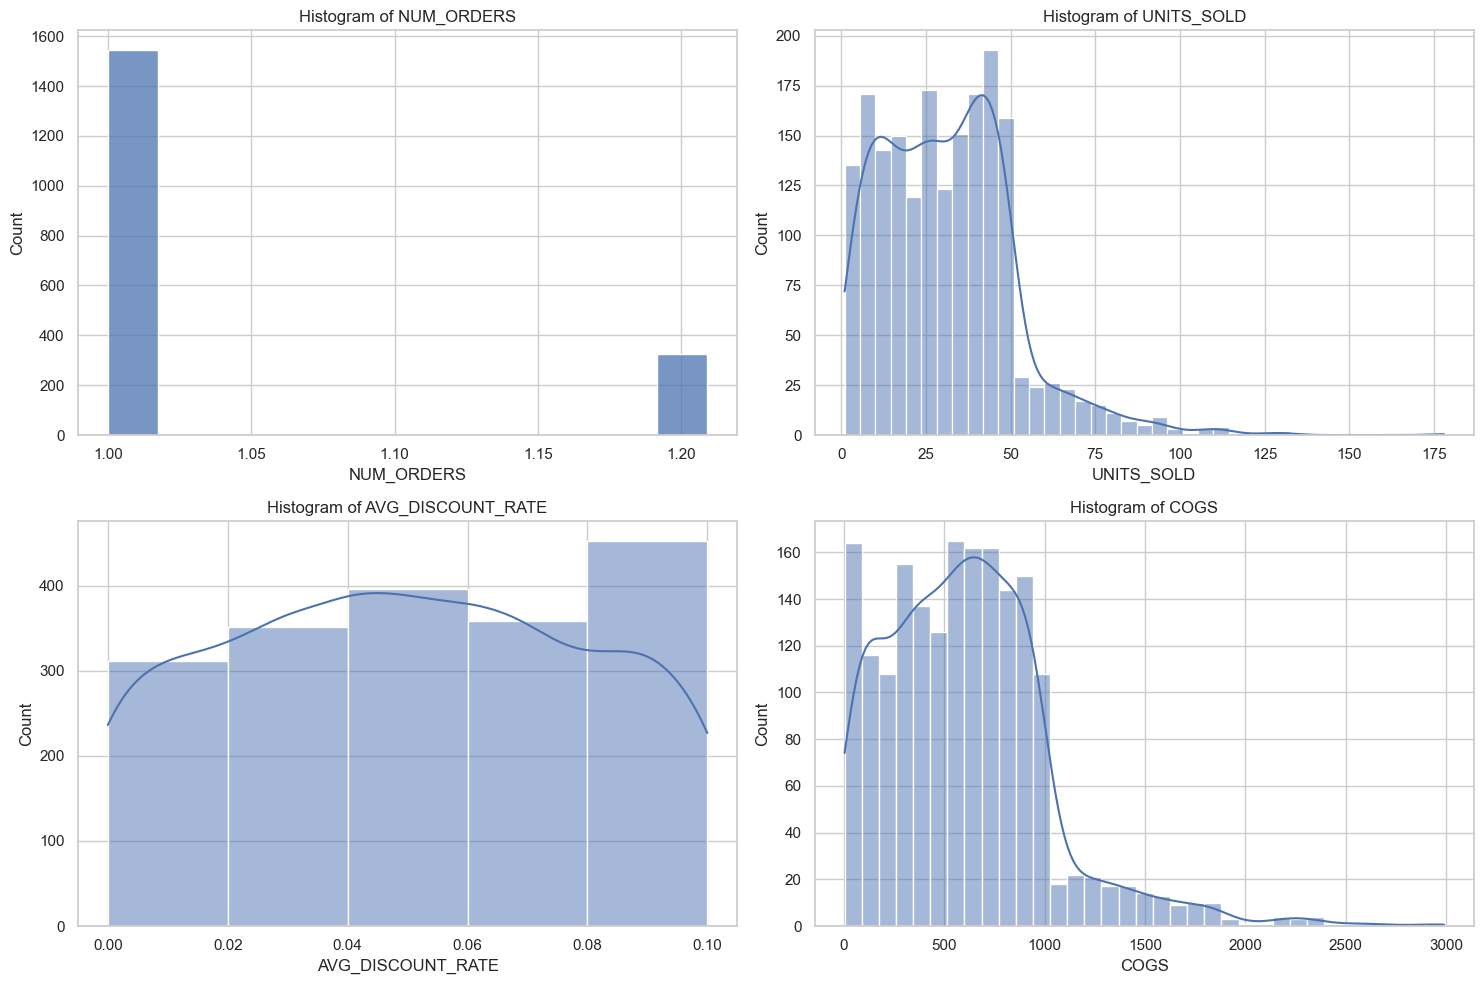

In [222]:
# Plot histograms for numeric features to understand their distribution
columns_for_hist = ['NUM_ORDERS','UNITS_SOLD', 'AVG_DISCOUNT_RATE', 'COGS']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot each numerical column
for ax, column in zip(axes.flatten(), columns_for_hist):
    if column == 'AVG_DISCOUNT_RATE':
        sns.histplot(df_raw_data[column], kde=True, bins=5, ax=ax)  # 4 or 5 bins
    elif column == 'NUM_ORDERS':
        sns.histplot(df_raw_data[column], ax=ax)
    else:
        sns.histplot(df_raw_data[column], kde=True, ax=ax)
    ax.set_title(f'Histogram of {column}')

# Adjust layout
plt.tight_layout()
plt.show()

In [223]:
# Calculate skewness and kurtosis for each numerical column
skewness = df_raw_data[numerical_columns].skew()
kurtosis = df_raw_data[numerical_columns].kurt()

print("Skewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)

Skewness:
 NUM_ORDERS           1.727995
UNITS_SOLD           1.115989
AVG_DISCOUNT_RATE    0.010766
COGS                 1.242960
dtype: float64

Kurtosis:
 NUM_ORDERS           0.987022
UNITS_SOLD           3.118831
AVG_DISCOUNT_RATE   -1.102402
COGS                 3.158592
dtype: float64


In [224]:
# Convert DATE column to datetime
df_raw_data['DATE'] = pd.to_datetime(df_raw_data['DATE'])

df_raw_data['DATE_ORDINAL'] = df_raw_data['DATE'].apply(lambda x: x.toordinal())

df_raw_data.head()

,DATE,RETAIL_RPICE,CUSTOMER_SEGMENT,NUM_ORDERS,UNITS_SOLD,AVG_DISCOUNT_RATE,COGS,DATE_ORDINAL
0,2021-01-01,1493.11465,7,1.0,39,0.09,843.43,737791
1,2021-01-02,1493.11465,9,1.0,49,0.08,851.13,737792
2,2021-01-02,1493.11465,8,1.0,4,0.05,318.59,737792
3,2021-01-02,1493.11465,6,1.0,6,0.10,963.42,737792
4,2021-01-02,1493.11465,4,1.0,10,0.10,450.51,737792


In [225]:
retail_price = df_raw_data['RETAIL_RPICE'][0]

In [226]:
# Select all columns except 'RETAIL_RPICE'
df_selected = df_raw_data.drop(columns=['RETAIL_RPICE', 'DATE'])

# Display the first few rows to verify the changes
df_selected.head()

,CUSTOMER_SEGMENT,NUM_ORDERS,UNITS_SOLD,AVG_DISCOUNT_RATE,COGS,DATE_ORDINAL
0,7,1.0,39,0.09,843.43,737791
1,9,1.0,49,0.08,851.13,737792
2,8,1.0,4,0.05,318.59,737792
3,6,1.0,6,0.10,963.42,737792
4,4,1.0,10,0.10,450.51,737792


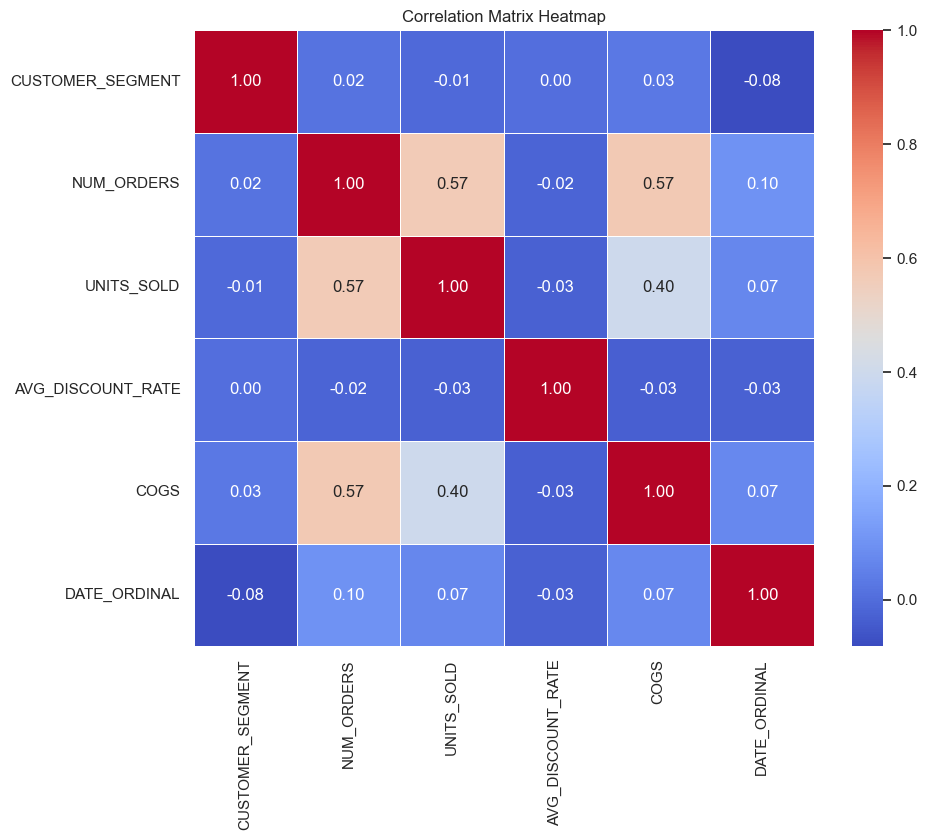

In [227]:
# Calculate the correlation matrix
corr_matrix = df_selected.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Frequency Distribution of CUSTOMER_SEGMENT:
 CUSTOMER_SEGMENT
4    381
7    324
6    310
9    257
3    240
1    234
5     56
8     45
2     23
Name: count, dtype: int64


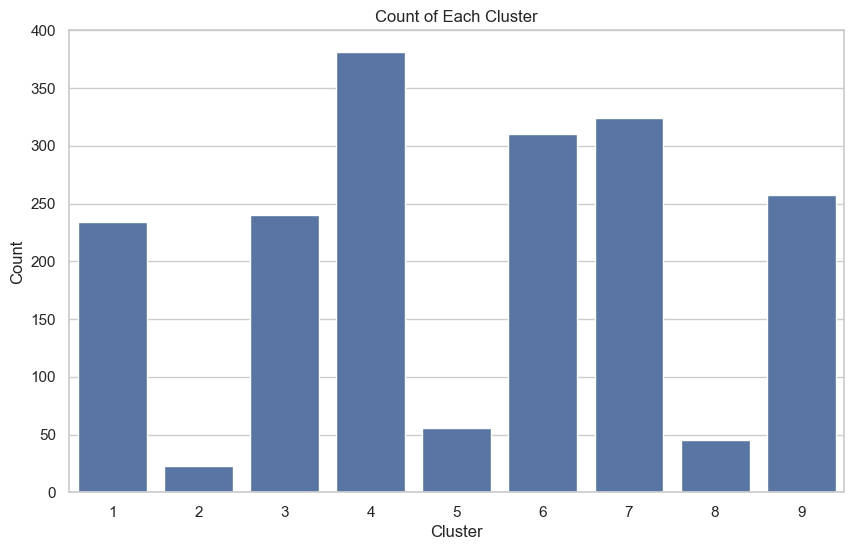

Cross-tabulation between CLUSTER and NUM_ORDERS:
 NUM_ORDERS        1.000000  1.209091
CUSTOMER_SEGMENT                    
1                      206        28
2                       22         1
3                      208        32
4                      282        99
5                       52         4
6                      247        63
7                      276        48
8                       41         4
9                      212        45


In [228]:
# Frequency Distribution
cluster_counts = df_raw_data['CUSTOMER_SEGMENT'].value_counts()
print("Frequency Distribution of CUSTOMER_SEGMENT:\n", cluster_counts)

# Bar Plots
plt.figure(figsize=(10, 6))
sns.countplot(x='CUSTOMER_SEGMENT', data=df_raw_data)
plt.title('Count of Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Cross-tabulation
cross_tab = pd.crosstab(df_raw_data['CUSTOMER_SEGMENT'], df_raw_data['NUM_ORDERS'])
print("Cross-tabulation between CLUSTER and NUM_ORDERS:\n", cross_tab)

In [229]:
# Select the required columns for independent variables and target variable
df_model = df_raw_data[['DATE_ORDINAL', 'UNITS_SOLD', 'CUSTOMER_SEGMENT', 'AVG_DISCOUNT_RATE']]

# Display the first few rows to verify the changes
df_model.head()

,DATE_ORDINAL,UNITS_SOLD,CUSTOMER_SEGMENT,AVG_DISCOUNT_RATE
0,737791,39,7,0.09
1,737792,49,9,0.08
2,737792,4,8,0.05
3,737792,6,6,0.10
4,737792,10,4,0.10


In [230]:
df_model['CUSTOMER_SEGMENT'] = df_model['CUSTOMER_SEGMENT'].astype('int')

C:\Users\panha.vuthy\AppData\Local\Temp\ipykernel_21988\2429274606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['CUSTOMER_SEGMENT'] = df_model['CUSTOMER_SEGMENT'].astype('int')


In [231]:
from sklearn.model_selection import train_test_split

# Split the dataset into 80% training and 20% testing
train_set, test_set = train_test_split(df_model, test_size=0.2, random_state=42)

# Display the size of the training and testing sets
print(f"Training set size: {len(train_set)}")
print(f"Testing set size: {len(test_set)}")

Training set size: 1496
Testing set size: 374


In [232]:
# Function to create the table if it doesn't exist
def create_table_if_not_exists(table_name):
    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        DATE_ORDINAL INT,
        UNITS_SOLD INT,
        CUSTOMER_SEGMENT INT,
        AVG_DISCOUNT_RATE FLOAT,
        PRODUCT_SKU STRING
    );
    """
    session.sql(create_table_query).collect()  # Execute the query

In [233]:
# Function to insert the pandas dataframe into Snowflake table using Snowpark
def insert_pandas_dataframe_to_snowflake(session, pandas_df, table_name, schema):
    # Convert pandas DataFrame to Snowpark DataFrame
    snowpark_df = session.create_dataframe(pandas_df, schema=schema)

    # Write the Snowpark DataFrame into Snowflake table
    session.sql(f"DELETE FROM {table_name} WHERE PRODUCT_SKU = '{product_sku}'").collect()
    snowpark_df.write.mode("append").save_as_table(f"{table_name}")
    return snowpark_df

In [234]:
df_model['PRODUCT_SKU'] = product_sku

C:\Users\panha.vuthy\AppData\Local\Temp\ipykernel_21988\2422108455.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['PRODUCT_SKU'] = product_sku


In [235]:
from snowflake.snowpark.types import StructType, StructField, IntegerType, FloatType, StringType

training_table = "FACT_DYNAMIC_PRICING_CLEANED"
# schema structure for pandas DataFrame convert to Snowpark DataFrame
schema = StructType([
        StructField("DATE_ORDINAL", IntegerType()),
        StructField("UNITS_SOLD", IntegerType()),
        StructField("CUSTOMER_SEGMENT", IntegerType()),
        StructField("AVG_DISCOUNT_RATE", FloatType()),
        StructField("PRODUCT_SKU", StringType())
    ])

create_table_if_not_exists(training_table)
snowpark_df = insert_pandas_dataframe_to_snowflake(session, df_model, training_table, schema)
# Convert pandas DataFrame to Snowpark DataFrame

In [236]:
from snowflake.snowpark.types import StructType, StructField, IntegerType, FloatType, StringType

training_table = "FACT_DYNAMIC_PRICING_CLEANED"
# schema structure for pandas DataFrame convert to Snowpark DataFrame
schema = StructType([
        StructField("DATE_ORDINAL", IntegerType()),
        StructField("UNITS_SOLD", IntegerType()),
        StructField("CUSTOMER_SEGMENT", IntegerType()),
        StructField("AVG_DISCOUNT_RATE", FloatType()),
        StructField("PRODUCT_SKU", StringType())
    ])

create_table_if_not_exists(training_table)
snowpark_df = insert_pandas_dataframe_to_snowflake(session, df_model, training_table, schema)
# Convert pandas DataFrame to Snowpark DataFrame

In [237]:
# Create a Stage
stage_name = "DYNAMIC_PRICING_MODEL_STAGE"
session.sql(f"CREATE STAGE IF NOT EXISTS {stage_name}").collect()

[Row(status='DYNAMIC_PRICING_MODEL_STAGE already exists, statement succeeded.')]

In [238]:
#from sklearn.model_selection import train_test_split

def train_xgb_model_with_defor(
    session: Session,
    training_table: str,
    feature_cols: list,
    target_col: str,
    model_name: str,
    stage_name: str
) ->T.Variant:
    # Import the package
    from sklearn.model_selection import GridSearchCV
    from xgboost import XGBRegressor
    from joblib import dump

    # Get training data 
    df_cleaned = session.table(training_table).to_pandas()

    train_set, test_set = train_test_split(df_cleaned, test_size=0.2, random_state=42)
    
    X_train = train_set[feature_cols]
    y_train = train_set[target_col]
    X_test = test_set[feature_cols]
    y_test = test_set[target_col]

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 7],
        'learning_rate': [0.2, 0.3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    # Initialize the XGBRegressor
    xgb = XGBRegressor()
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_xgb = XGBRegressor(**best_params)
    best_xgb.fit(X_train, y_train)
    y_pred = best_xgb.predict(X_test)

    mse = np.mean((y_pred - y_test) ** 2)

    print("Mean Squared Error: ", mse)
    # Save model
    dump(best_xgb, "/tmp/"+ model_name)
    session.file.put(
        "/tmp/"+ model_name,
        f"@{stage_name}/",
        auto_compress=False,
        overwrite=True
    )
    
    # combine mse and best_params into a dictionary
    result = {"mse": mse, "best_params": best_params}
    return result
    

In [239]:
# train_xgb_snowflake become a stored procedure in Snowflake that can be called
train_xgb_snowflake = session.sproc.register(
    func=train_xgb_model_with_defor,
    name="sproc_train_xgb_model_with_defor", #spoc = stored procedure or function in snowflake
    is_permanent=True,
    replace=True,
    stage_location=stage_name,
    packages=["snowflake-snowpark-python", "scikit-learn", "xgboost", "joblib"],
)

Got error object of type 'NoneType' has no len() when trying to read default values from function: <function train_xgb_model_with_defor at 0x0000020BDA5C71A0>. Proceeding without creating optional arguments
The version of package 'scikit-learn' in the local environment is 1.5.2, which does not fit the criteria for the requirement 'scikit-learn'. Your UDF might not work when the package version is different between the server and your local environment.


In [240]:
training_table = "FACT_DYNAMIC_PRICING_CLEANED"
model_file_name = "B33_S3_xgb_model.sav"
feature_cols = [
    'DATE_ORDINAL',
    'UNITS_SOLD',
    'CUSTOMER_SEGMENT'
]
target_col = 'AVG_DISCOUNT_RATE'

# Call the training store procedure by feeding the required parameters
result = train_xgb_snowflake(
    session,
    training_table,
    feature_cols, 
    target_col, 
    model_file_name,
    stage_name # where model file will be stored
)
result

'{\n  "best_params": {\n    "colsample_bytree": 8.000000000000000e-01,\n    "learning_rate": 2.000000000000000e-01,\n    "max_depth": 5,\n    "n_estimators": 100,\n    "subsample": 1.000000000000000e+00\n  },\n  "mse": 8.394864003169793e-04\n}'

In [241]:
pd.DataFrame(session.sql(f"LIST @{stage_name}").collect())

,name,size,md5,last_modified
0,dynamic_pricing_model_stage/B12_S10_xgb_model.sav,261344,d5548160396c02a8882e8b9b30977057,"Fri, 11 Oct 2024 08:02:01 GMT"
1,dynamic_pricing_model_stage/B13_S1_xgb_model.sav,246336,28ab48d025bf82279b46f6ad7cda2bdb,"Fri, 11 Oct 2024 07:17:51 GMT"
2,dynamic_pricing_model_stage/B15_S1_xgb_model.sav,246800,b8f9bc5150e3118c4af0d39f8a3be20d,"Fri, 11 Oct 2024 07:06:09 GMT"
3,dynamic_pricing_model_stage/B15_S47_xgb_model.sav,271136,413a8168a21d93adeebe9dcb0a130717,"Tue, 15 Oct 2024 04:25:49 GMT"
4,dynamic_pricing_model_stage/B22_S10_xgb_model.sav,266928,8d9c2baa83889a42e87b8bd7be94cbc1,"Fri, 11 Oct 2024 07:54:29 GMT"
5,dynamic_pricing_model_stage/B31_S32_xgb_model.sav,252112,8a886709685b5bbb7311c13a10804995,"Fri, 11 Oct 2024 07:24:02 GMT"
6,dynamic_pricing_model_stage/B33_S3_xgb_model.sav,258832,7dade521b78747b9de1bd79a0ad569fc,"Wed, 16 Oct 2024 09:55:27 GMT"
7,dynamic_pricing_model_stage/B44_S4_xgb_model.sav,225520,a8b7d76e01b4274ec22911d7f81fe16f,"Tue, 15 Oct 2024 03:17:44 GMT"
8,dynamic_pricing_model_stage/udf_avg_discount_r...,6304,39ba2fd3cbf388d108cdc6356e1a6406,"Tue, 8 Oct 2024 08:14:20 GMT"
9,dynamic_pricing_model_stage/udf_avg_discount_r...,6304,1aa7f9cc1cef0999d43a2e849510b1a6,"Thu, 10 Oct 2024 07:46:40 GMT"


In [242]:
import cachetools
@cachetools.cached(cache={})
def load_model(filename):

    # Import packages
    import sys
    import os
    import joblib

    # Get the import directory where the model file is stored
    import_dir = sys._xoptions.get("snowflake_import_directory")

    # Get the import directory where the model file is stored
    if import_dir:
        with open(os.path.join(import_dir, filename), "rb") as f:
            model = joblib.load(f)
            return model
        
# Function to predict the average discount rate
def avg_discount_rate_prediction_test(date_ordinal: int, units_sold: int, customer_segment: int, model_name: str) -> float:
    import pandas as pd
    # Create a DataFrame from the input values (this assumes feature_cols)
    feature_cols = ['DATE_ORDINAL', 'UNITS_SOLD', 'CUSTOMER_SEGMENT']
    X = pd.DataFrame([[date_ordinal, units_sold, customer_segment]], columns=feature_cols)

    # Load the model using the model name
    model = load_model(model_name)

    # Get predictions
    predictions = model.predict(X)

    # Return the predicted value (assuming a regression model returning a single value)
    return predictions[0]


In [243]:
session.udf.register(
    func=avg_discount_rate_prediction_test,
    name="udf_avg_discount_rate_prediction_test",
    stage_location=stage_name,
    input_type=[T.IntegerType(), T.IntegerType(), T.IntegerType(), T.StringType()],  # Three integers and one string
    return_type=T.FloatType(),  # The return type is a float
    replace=True,
    is_permanent=True,
    imports=[f"@{stage_name}/{model_file_name}"],  # Model file is imported,
    # imports=[f"@{stage_name}/{model}" for model in model_files], # multiple model files are imported, 
    packages=["joblib", "cachetools", "xgboost","pandas"],  # Required packages for the UDF
)

Got error object of type 'NoneType' has no len() when trying to read default values from function: <function avg_discount_rate_prediction_test at 0x0000020B820E07C0>. Proceeding without creating optional arguments
The version of package 'cachetools' in the local environment is 5.5.0, which does not fit the criteria for the requirement 'cachetools'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'pandas' in the local environment is 2.2.3, which does not fit the criteria for the requirement 'pandas'. Your UDF might not work when the package version is different between the server and your local environment.


In [244]:
import snowflake.snowpark.functions as F

In [245]:
# Call the UDF to predict the average discount rate


result_test = session.sql("""
SELECT udf_avg_discount_rate_prediction_test(738409, 67, 1, 'B33_S3_xgb_model.sav') as PREDICTED_AVG_DISCOUNT_RATE
""").collect()

In [246]:
result_test[0]

Row(PREDICTED_AVG_DISCOUNT_RATE=0.05174129456281662)

In [2]:
import joblib

# Load the ARIMA model from the file
model_path = './models/B33_S3/B33_S3_c7.pkl'
model = joblib.load(model_path)

# Predict future sales for the next 7 days
n_periods = 7
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# Create a DataFrame for the forecast
# forecast_index = pd.date_range(start=segment_data['DATE'].iloc[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D')
# forecast_df = pd.DataFrame(forecast, columns=['UNITS_SOLD'], index=forecast_index)
# forecast_df['UNITS_SOLD'] = forecast.values
# # Print the forecast
# print(forecast_df)


In [10]:
import json
result = {
        'forecast': forecast.tolist(),
        'confidence_interval': conf_int.tolist(),
    }
    # result string
result_str = json.dumps(result)
type(result_str)

str

In [248]:
# Calculate the total units sold in the forecast
total_units_sold = forecast.sum()

# Calculate the weight as a percentage for each date of prediction
forecast_df['Weight_Percentage'] = (forecast_df['UNITS_SOLD'] / total_units_sold) * 100

# Print the forecast with weight percentage
print(forecast_df)

            UNITS_SOLD  Weight_Percentage
2023-08-03    8.779575          14.298270
2023-08-04   13.858223          22.569273
2023-08-05    5.236436           8.527973
2023-08-06   11.279964          18.370362
2023-08-07    8.319084          13.548322
2023-08-08    7.897350          12.861494
2023-08-09    6.032424           9.824306


In [249]:
expected_units_sold = 700
volume_sold_by_date = (forecast_df['Weight_Percentage'] / 100) * expected_units_sold
volume_sold_by_date
print(volume_sold_by_date.to_list())

[100.08789323872261, 157.98491137442173, 59.69580791660724, 128.59253657520986, 94.8382530035488, 90.03045749223126, 68.77014039925847]


In [250]:
sample_data = {
    'UNITS_SOLD': volume_sold_by_date.to_list(),
    'DATE_ORDINAL': [738409, 738410, 738411, 738412, 738413, 738414, 738415],
    'CUSTOMER_SEGMENT': [7, 7, 7, 7, 7, 7, 7],
}
snowpark_df_sample = session.create_dataframe(pd.DataFrame(sample_data))
snowpark_df_sample.show()

------------------------------------------------------------
|"UNITS_SOLD"        |"DATE_ORDINAL"  |"CUSTOMER_SEGMENT"  |
------------------------------------------------------------
|100.08789323872261  |738409          |7                   |
|157.98491137442173  |738410          |7                   |
|59.69580791660724   |738411          |7                   |
|128.59253657520986  |738412          |7                   |
|94.8382530035488    |738413          |7                   |
|90.03045749223126   |738414          |7                   |
|68.77014039925847   |738415          |7                   |
------------------------------------------------------------



In [251]:
result_test = snowpark_df_sample.select(
    "UNITS_SOLD",
    "DATE_ORDINAL",
    "CUSTOMER_SEGMENT",
    F.call_udf("udf_avg_discount_rate_prediction_test", 
            snowpark_df_sample['DATE_ORDINAL'],
            snowpark_df_sample['UNITS_SOLD'], 
            snowpark_df_sample['CUSTOMER_SEGMENT'], 
            "B33_S3_xgb_model.sav").alias('PREDICTED_AVG_DISCOUNT_RATE')
)
results = result_test.collect()

# Print the results
for i, row in enumerate(results):
    print(f"Prediction for row {i}: {row['PREDICTED_AVG_DISCOUNT_RATE']}")

Prediction for row 0: 0.054591335356235504
Prediction for row 1: 0.06611154973506927
Prediction for row 2: 0.05606689676642418
Prediction for row 3: 0.03820158168673515
Prediction for row 4: 0.04888016730546951
Prediction for row 5: 0.05807872116565704
Prediction for row 6: 0.056207239627838135


In [252]:
# Find the minimum and maximum values for PREDICTED_AVG_DISCOUNT_RATE
predicted_discount_rates = [row['PREDICTED_AVG_DISCOUNT_RATE'] for row in results]

# Calculate the minimum value from the 'PREDICTED_AVG_DISCOUNT_RATE' column
min_discount_rate = min(predicted_discount_rates)
max_discount_rate = max(predicted_discount_rates)
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [253]:
expected_units_sold = 700
each_cluster_average_discount_rate = []
for i in customer_segement:
    model_path = f'./models/B33_S3/B33_S3_c{i}.pkl'
    model = joblib.load(model_path)

    # Predict future sales for the next 7 days
    n_periods = 7
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

    # Create a DataFrame for the forecast
    forecast_index = pd.date_range(start=segment_data['DATE'].iloc[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D')
    forecast_df = pd.DataFrame(forecast, columns=['UNITS_SOLD'], index=forecast_index)
    forecast_df['UNITS_SOLD'] = forecast.values
    total_units_sold = forecast.sum()

    # Calculate the weight as a percentage for each date of prediction
    forecast_df['Weight_Percentage'] = (forecast_df['UNITS_SOLD'] / total_units_sold) * 100

    volume_sold_by_date = (forecast_df['Weight_Percentage'] / 100) * expected_units_sold
    sample_data = {
        'UNITS_SOLD': volume_sold_by_date.to_list(),
        'DATE_ORDINAL': [738643, 738644, 738645, 738646, 738647, 738648, 738649],
        'CUSTOMER_SEGMENT': [i, i, i, i, i, i, i],
    }
    snowpark_df_sample = session.create_dataframe(pd.DataFrame(sample_data))
    result_test = snowpark_df_sample.select(
    "UNITS_SOLD",
    "DATE_ORDINAL",
    "CUSTOMER_SEGMENT",
    F.call_udf("udf_avg_discount_rate_prediction_test", 
            snowpark_df_sample['DATE_ORDINAL'],
            snowpark_df_sample['UNITS_SOLD'], 
            snowpark_df_sample['CUSTOMER_SEGMENT'], 
            "B33_S3_xgb_model.sav").alias('PREDICTED_AVG_DISCOUNT_RATE')
    )
    results = result_test.collect()
    predicted_discount_rates = [row['PREDICTED_AVG_DISCOUNT_RATE'] for row in results]

    # Calculate the minimum value from the 'PREDICTED_AVG_DISCOUNT_RATE' column
    min_discount_rate = min(predicted_discount_rates)
    max_discount_rate = max(predicted_discount_rates)
    each_cluster_average_discount_rate.append({
            'min_discount_rate': min_discount_rate,
            'max_discount_rate': max_discount_rate
        })
    print(f"Customer Segment {i}: Min Discount Rate: {min_discount_rate}, Max Discount Rate: {max_discount_rate}")


Customer Segment 1: Min Discount Rate: 0.03751421719789505, Max Discount Rate: 0.0548778735101223
Customer Segment 2: Min Discount Rate: 0.04740894213318825, Max Discount Rate: 0.05550218001008034
Customer Segment 3: Min Discount Rate: 0.049389615654945374, Max Discount Rate: 0.05613422766327858
Customer Segment 4: Min Discount Rate: 0.050703179091215134, Max Discount Rate: 0.051440395414829254
Customer Segment 5: Min Discount Rate: 0.05155820772051811, Max Discount Rate: 0.05304878205060959
Customer Segment 6: Min Discount Rate: 0.05148230120539665, Max Discount Rate: 0.05221951752901077
Customer Segment 7: Min Discount Rate: 0.034135229885578156, Max Discount Rate: 0.05652811378240585
Customer Segment 8: Min Discount Rate: 0.04685564339160919, Max Discount Rate: 0.04760900139808655
Customer Segment 9: Min Discount Rate: 0.029311077669262886, Max Discount Rate: 0.04959729686379433


In [254]:
each_cluster_average_discount_rate

[{'min_discount_rate': 0.03751421719789505,
  'max_discount_rate': 0.0548778735101223},
 {'min_discount_rate': 0.04740894213318825,
  'max_discount_rate': 0.05550218001008034},
 {'min_discount_rate': 0.049389615654945374,
  'max_discount_rate': 0.05613422766327858},
 {'min_discount_rate': 0.050703179091215134,
  'max_discount_rate': 0.051440395414829254},
 {'min_discount_rate': 0.05155820772051811,
  'max_discount_rate': 0.05304878205060959},
 {'min_discount_rate': 0.05148230120539665,
  'max_discount_rate': 0.05221951752901077},
 {'min_discount_rate': 0.034135229885578156,
  'max_discount_rate': 0.05652811378240585},
 {'min_discount_rate': 0.04685564339160919,
  'max_discount_rate': 0.04760900139808655},
 {'min_discount_rate': 0.029311077669262886,
  'max_discount_rate': 0.04959729686379433}]

In [255]:
price_ranges = []

for discount_rate in each_cluster_average_discount_rate:
    min_price = retail_price * (1 - discount_rate['max_discount_rate'])
    max_price = retail_price * (1 - discount_rate['min_discount_rate'])
    price_ranges.append({
        'min_price': min_price,
        'max_price': max_price
    })

print(f"Retail Price of Product SKU {product_sku}: {retail_price}")
for i, price_range in enumerate(price_ranges):
    print(f"Customer Segment {i + 1}: Price Range: {price_range['min_price']} - {price_range['max_price']}")

Retail Price of Product SKU B12_S10: 1493.11464956
Customer Segment 1: Price Range: 1411.175692685336 - 1437.1016222950473
Customer Segment 2: Price Range: 1410.243531504433 - 1422.3276635407944
Customer Segment 3: Price Range: 1409.2998118942226 - 1419.3702908894631
Customer Segment 4: Price Range: 1416.3082415869594 - 1417.4089900796425
Customer Segment 5: Price Range: 1413.9067359389194 - 1416.132334307437
Customer Segment 6: Price Range: 1415.1449229444788 - 1416.245671437162
Customer Segment 7: Price Range: 1408.7116947594955 - 1442.1468377517451
Customer Segment 8: Price Range: 1422.0289521215946 - 1423.1538019974291
Customer Segment 9: Price Range: 1419.0601990340924 - 1449.3498500976327


In [256]:
from datetime import datetime

def ordinal_to_date(date_ordinal):
    """
    Convert a date ordinal to a simple date.
    
    Parameters:
    date_ordinal (int): The date ordinal to convert.
    
    Returns:
    datetime.date: The corresponding date.
    """
    return datetime.fromordinal(date_ordinal).date()

# Example usage
date_ordinal = 738643
simple_date = ordinal_to_date(date_ordinal)
print(simple_date)

2023-05-03
